In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [3]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

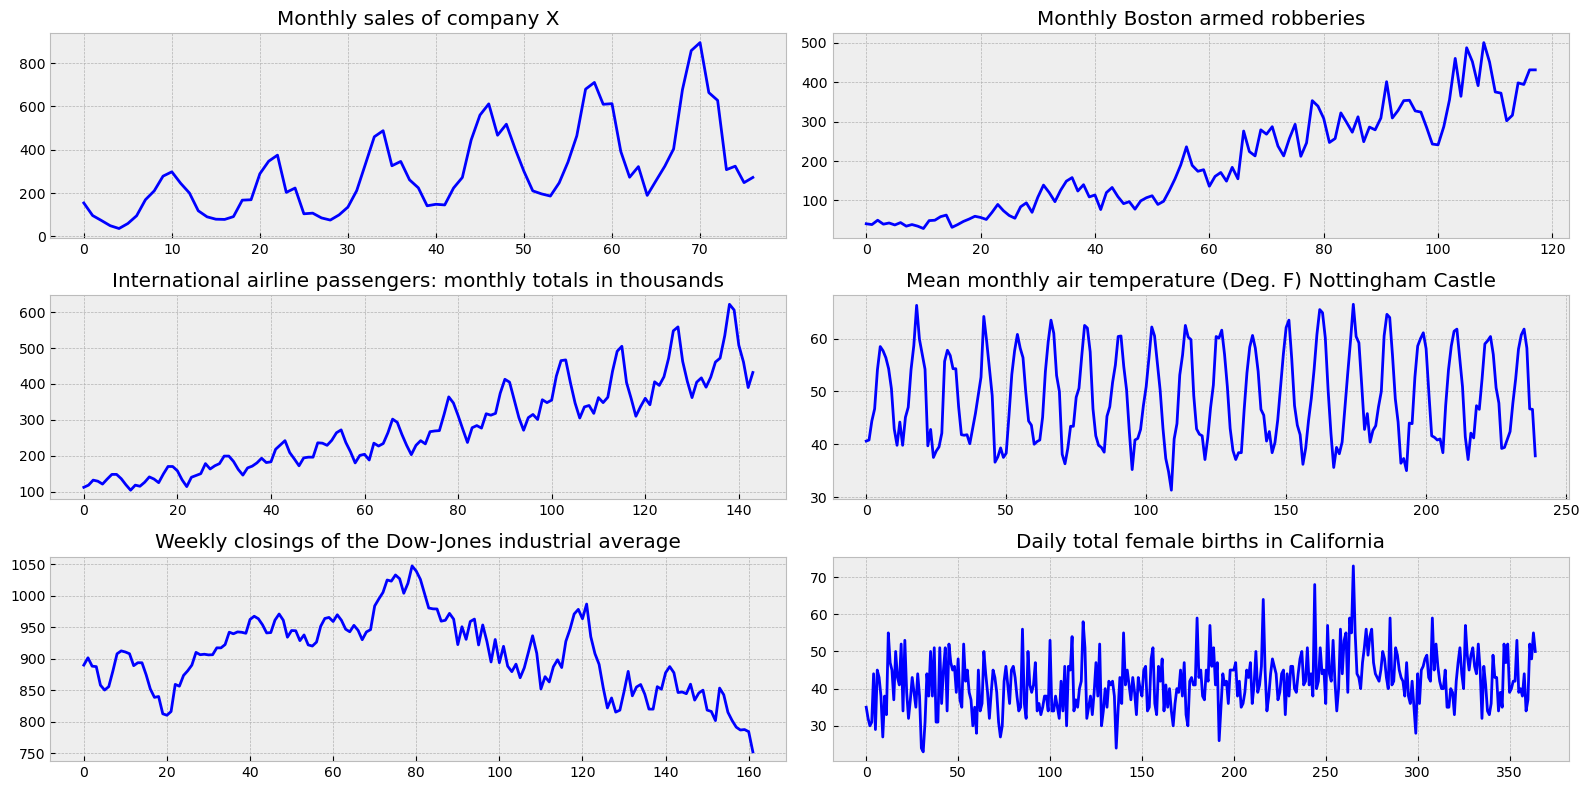

In [4]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [5]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [6]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [7]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [8]:
def plot_tema(alpha, beta, gamma, ser=None, ser_to_plot=None, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [9]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

### International airline passengers: monthly totals in thousands

In [10]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [11]:
series_1 = all_series['International airline passengers: monthly totals in thousands']

In [12]:
train, test, val = series_1[:100], series_1[100:120], series_1[120:]
test, val = test.reset_index(drop=True), val.reset_index(drop=True)

In [13]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [14]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 1325.167400914664
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.21723745e+01,  1.36424205e-04, -0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 7
     njev: 12
   status: 0
  success: True
        x: array([1.        , 0.01108357, 1.        ])


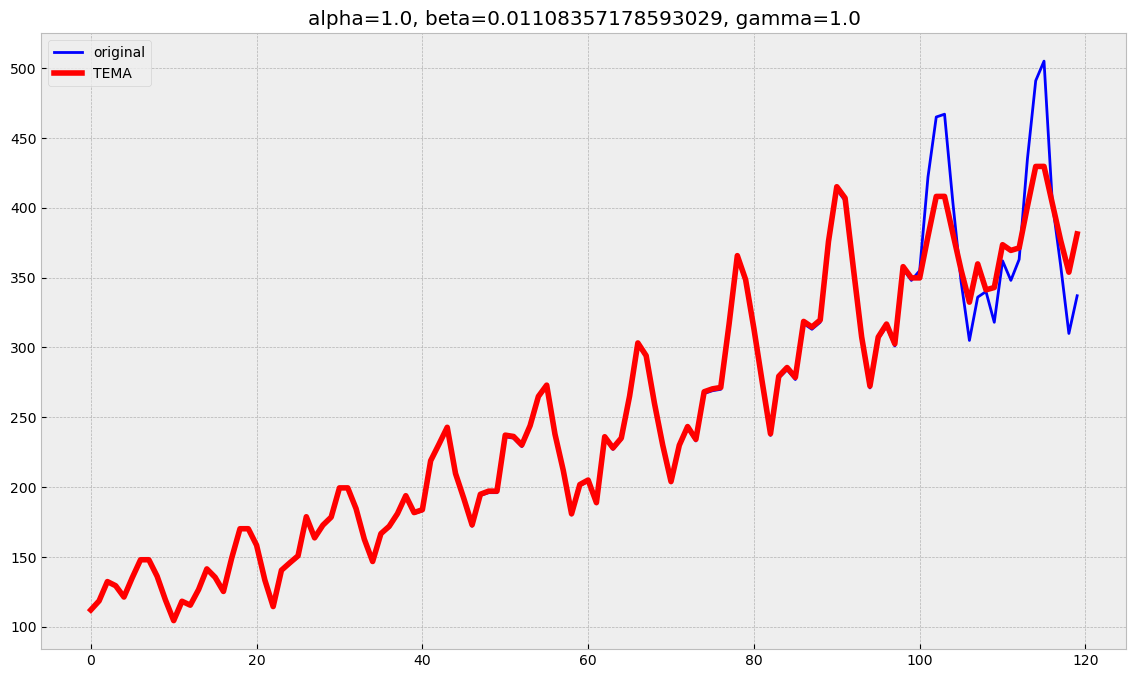

In [15]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series_1[:120], n_preds=len(test))

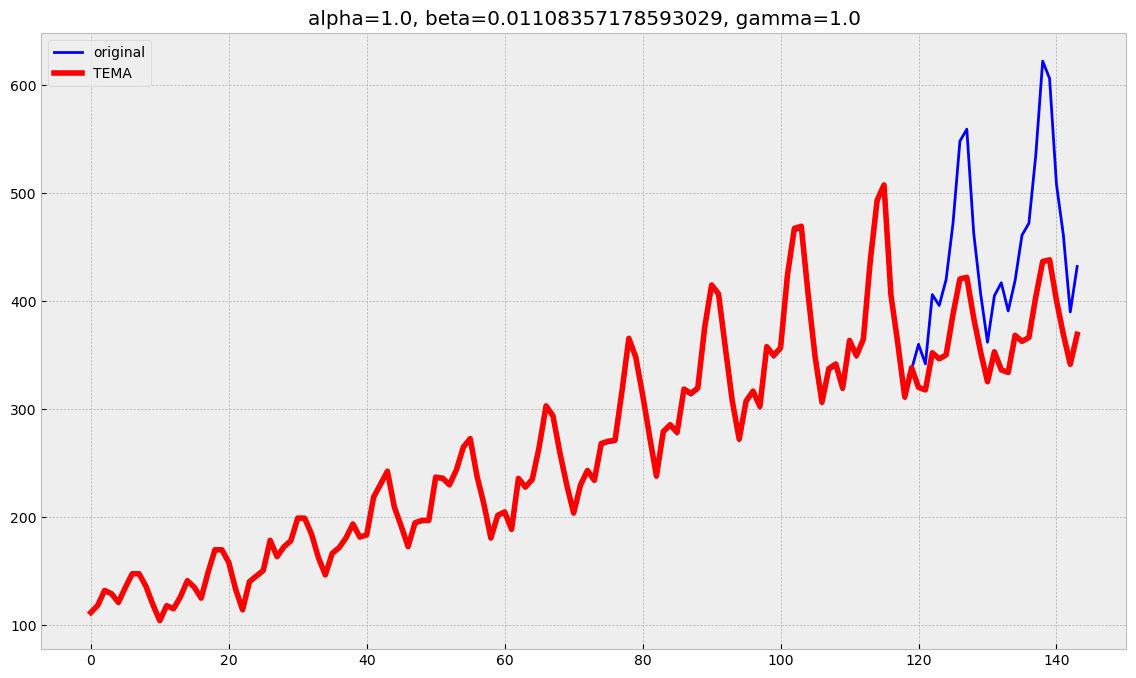

In [16]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series_1[:120], ser_to_plot=series_1, n_preds=len(val))

Было использовано тройное экспоненциальное сглаживание, т.к. временной ряд обладает явно выраженным трендом и сезонностью.

### Daily total female births in California

In [17]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [18]:
series_2 = all_series['Daily total female births in California']

In [19]:
train, test, val = series_2[:300], series_2[300:330], series_2[330:]
test, val = test.reset_index(drop=True), val.reset_index(drop=True)

In [20]:
def mse(X):
    alpha  = X
    result = exponential_moving_average(train, X)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [21]:
opt = minimize(mse, x0=[0], method="Nelder-Mead", bounds = [(0, 1)])

In [22]:
alpha_opt = opt.x
print(opt)

 final_simplex: (array([[0.0134375 ],
       [0.01346875]]), array([36.14156693, 36.14159522]))
           fun: 36.14156693313241
       message: 'Optimization terminated successfully.'
          nfev: 26
           nit: 13
        status: 0
       success: True
             x: array([0.0134375])


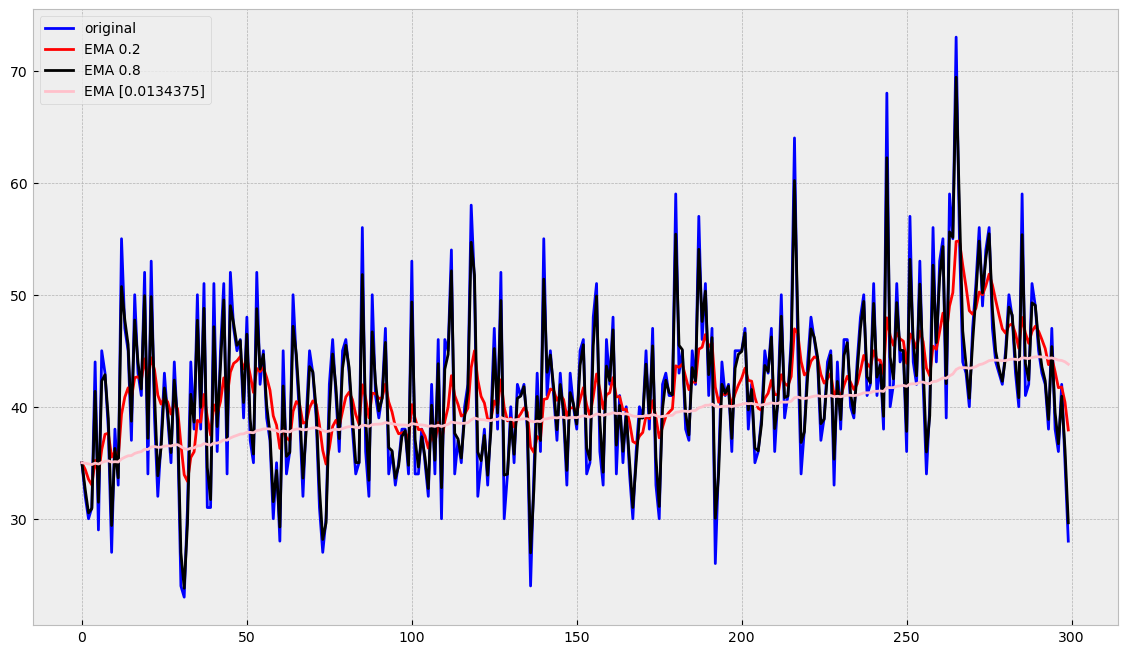

In [23]:
alphas = [0.2, 0.8, alpha_opt]
colors = ['red', 'black', 'pink']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(train, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(train, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

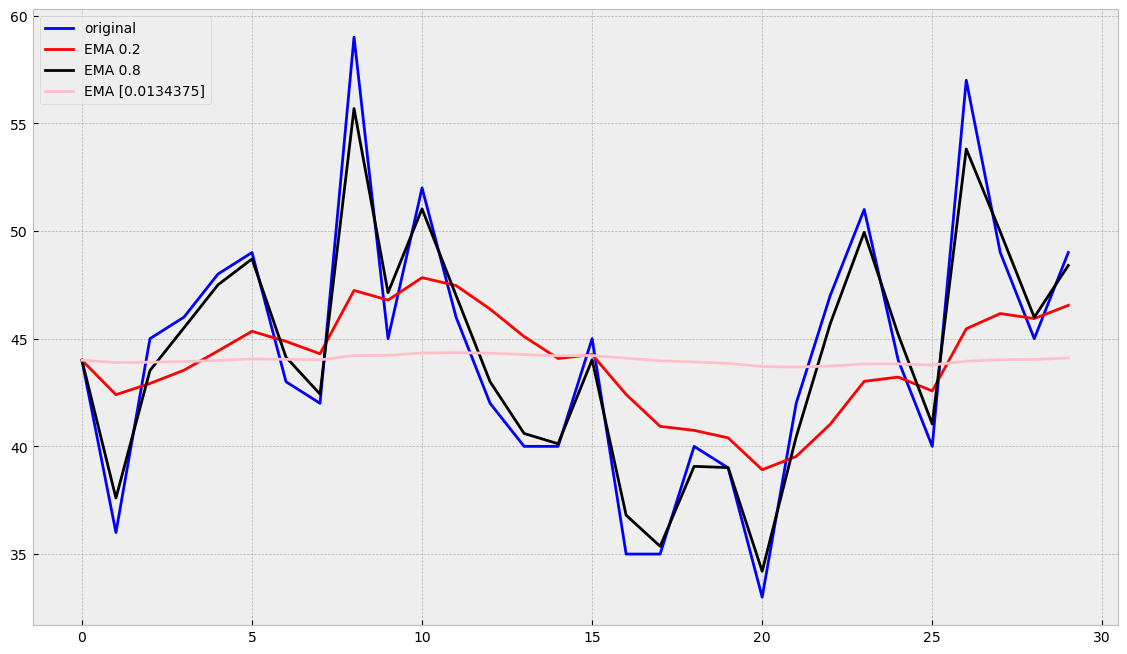

In [24]:
alphas = [0.2, 0.8, alpha_opt]
colors = ['red', 'black', 'pink']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(test, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(test, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

Для стационарного временного ряда без тренда и сезонности было применено простое экспоненциальное сглаживание